In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import requests
import re
import json


import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from scipy import stats

from factor_analyzer import Rotator
from factor_analyzer import FactorAnalyzer


from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Data Preprocessing

In [2]:
import pandas as pd
from sodapy import Socrata
client = Socrata("data.cityofnewyork.us", None)
results = client.get("7x5e-2fxh", limit=10000)
results_df = pd.DataFrame.from_records(results)

In [3]:
location_data_columns = ['property_id', 'latitude', 'longitude', 'borough', 'nta']

property_use_details_columns = [
    'primary_property_type',
    'largest_property_use_type',
    'largest_property_use_type_1',
    '_2nd_largest_property_use',
    '_2nd_largest_property_use_1',
    '_3rd_largest_property_use',
    'year_built',
    'construction_status',
    'number_of_buildings',
    'occupancy',
    'metered_areas_energy',
    'metered_areas_water',
    '_3rd_largest_property_use_1',
    'national_median_reference',
    'property_gfa_calculated_1',
    'last_modified_date_property',
    'last_modified_date_electric',
    'last_modified_date_gas_meters',
    'last_modified_date_non',
    'last_modified_date_water',
    'last_modified_date_property_1'
]

multifamily_columns=['multifamily_housing_government',
 'multifamily_housing_gross',
 'multifamily_housing_number',
 'multifamily_housing_number_1',
 'multifamily_housing_number_2',
 'multifamily_housing_number_3',
 'multifamily_housing_number_4',
 'multifamily_housing_total',
 'multifamily_housing_total_1',
 'multifamily_housing_number_5',
 'multifamily_housing_number_6',
 'multifamily_housing_number_7',
 'multifamily_housing_percent',
 'multifamily_housing_percent_1',
 'multifamily_housing_resident']

energy_use_metrics_columns = [
    'reason_s_for_no_score',
    'energy_star_score',
    'energy_star_certification',
    'energy_star_certification_1',
    'site_eui_kbtu_ft',
    'weather_normalized_site_eui',
    'national_median_site_eui',
    'site_energy_use_kbtu',
    'weather_normalized_site_energy',
    'weather_normalized_site',
    'weather_normalized_site_1',
    'source_eui_kbtu_ft',
    'weather_normalized_source',
    'national_median_source_eui',
    'source_energy_use_kbtu',
    'weather_normalized_source_1',
    'fuel_oil_1_use_kbtu',
    'fuel_oil_2_use_kbtu',
    'fuel_oil_4_use_kbtu',
    'fuel_oil_5_6_use_kbtu',
    'diesel_2_use_kbtu',
    'propane_use_kbtu',
    'district_steam_use_kbtu',
    'district_hot_water_use_kbtu',
    'district_chilled_water_use',
    'natural_gas_use_kbtu',
    'natural_gas_use_therms',
    'weather_normalized_site_2',
    'electricity_use_grid_purchase',
    'electricity_use_grid_purchase_1',
    'weather_normalized_site_3',
    'electricity_use_grid_purchase_2',
    'electricity_use_grid_purchase_3',
    'electricity_use_generated',
    'electricity_use_generated_1',
    'electricity_use_generated_2',
    'electricity_use_generated_3',
    'annual_maximum_demand_kw',
    'annual_maximum_demand_mm',
    'annual_maximum_demand_meter',
    'green_power_onsite_kwh',
    'green_power_offsite_kwh',
    'green_power_onsite_and_offsite',
    'total_ghg_emissions_metric',
    'direct_ghg_emissions_metric',
    'total_ghg_emissions_intensity',
    'direct_ghg_emissions_intensity',
    'indirect_ghg_emissions_metric',
    'net_emissions_metric_tons',
    'indirect_ghg_emissions',
    'national_median_total_ghg',
    'egrid_output_emissions_rate',
    'avoided_emissions_onsite',
    'avoided_emissions_offsite',
    'avoided_emissions_onsite_1',
    'percent_of_recs_retained',
    'percent_of_total_electricity',
    'water_use_all_water_sources',
    'municipally_supplied_potable',
    'municipally_supplied_potable_1',
    'municipally_supplied_potable_2',
    'municipally_supplied_potable_3'
]
data_quality_columns = [
    'estimated_data_flag',
    'estimated_data_flag_natural',
    'estimated_data_flag_fuel',
    'estimated_data_flag_fuel_1',
    'estimated_data_flag_fuel_2',
    'estimated_data_flag_fuel_3',
    'estimated_data_flag_district',
    'estimated_data_flag_1',
    'estimated_values_energy',
    'estimated_values_water',
    'alert_data_center_issue_with',
    'alert_energy_meter_has_less',
    'alert_energy_meter_has_gaps',
    'alert_energy_meter_has',
    'alert_energy_no_meters',
    'alert_energy_meter_has_single',
    'alert_water_meter_has_less',
    'alert_property_has_no_uses'
]

# Combine all columns into a single list
all_subset_columns = location_data_columns + property_use_details_columns + energy_use_metrics_columns + data_quality_columns+multifamily_columns

# Subset the dataframe based on these columns
df = results_df[all_subset_columns]

In [4]:
property_type_counts = results_df['largest_property_use_type'].value_counts()

# Calculate the proportion of 'Multi-family house'
multi_family_proportion = property_type_counts.get('Multifamily Housing', 0) / len(results_df)

In [5]:
multi_family_proportion

0.6925

In [6]:
# remove columns with  90% of "Not Available"
threshold= len(results_df)*0.1

count_not_available = results_df.applymap(lambda x: x == 'Not Available').sum()


# Filter the columns based on the count condition
filtered_columns = count_not_available[count_not_available <= threshold].index

# Create a new DataFrame with the filtered columns
filtered_df = results_df[filtered_columns]

In [7]:
len(filtered_df.columns.to_list())
df = filtered_df.drop(columns = [column for column in filtered_df.columns if 'alert' in column or 'estimated' in column])
df.head()
df.shape

83

,property_id,property_name,parent_property_id,parent_property_name,year_ending,nyc_borough_block_and_lot,nyc_building_identification,address_1,city,postal_code,primary_property_type_self,primary_property_type,national_median_reference,list_of_all_property_use,largest_property_use_type,largest_property_use_type_1,year_built,construction_status,number_of_buildings,occupancy,metered_areas_energy,national_median_energy_star,energy_star_certification_1,site_eui_kbtu_ft,national_median_site_eui,site_energy_use_kbtu,weather_normalized_site,source_eui_kbtu_ft,national_median_source_eui,source_energy_use_kbtu,electricity_use_grid_purchase,electricity_use_grid_purchase_1,weather_normalized_site_3,electricity_use_grid_purchase_2,electricity_use_grid_purchase_3,green_power_offsite_kwh,green_power_onsite_and_offsite,total_ghg_emissions_metric,direct_ghg_emissions_metric,total_ghg_emissions_intensity,direct_ghg_emissions_intensity,indirect_ghg_emissions_metric,net_emissions_metric_tons,indirect_ghg_emissions,national_median_total_ghg,egrid_output_emissions_rate,avoided_emissions_offsite,avoided_emissions_onsite_1,percent_of_electricity_that,default_values,temporary_values,property_gfa_self_reported,property_gfa_calculated,property_gfa_calculated_1,last_modified_date_property,last_modified_date_electric,last_modified_date_gas_meters,last_modified_date_property_1,number_of_active_energy_meters,number_of_active_energy_meters_1,number_of_active_energy_meters_2,number_of_active_it_meters,generation_date,submission_date,latitude,longitude,community_board,council_district,census_tract,nta,borough
0,21205224,Astoria Blvd Property,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2021-12-31T00:00:00.000,4006520042,4538607,36-16 Astoria Blvd.,Long Island City,11103,Multifamily Housing,Multifamily Housing,Fannie Mae Industry Survey - Multifamily,"Multifamily Housing, Parking",Multifamily Housing,25000,2010,Existing,1,100,Whole Property,50,No,66.7,76.1,1666390.8,7,112.3,128.1,2806470.4,603862.9,176982.1,173893.6,176982.1,603862.9,0,0,107.5,56.4,4.3,2.3,51.1,107.5,2,122.7,84.5,0,0,0,Yes,No,25000,34146,25000,07/11/2022 11:06 AM EDT,05/25/2022 05:12 PM EDT,07/11/2022 11:06 AM EDT,05/19/2022 09:25 AM EDT,8,8,0,0,2022-09-26T00:00:00.000,2022-09-26T00:00:00.000,40.769272,-73.913633,401,22,6502,Astoria,QUEENS
1,2665352,Stellar - 70 West 93rd Street,20599688,Stellar - Campus West 93rd Street,2021-12-31T00:00:00.000,1-01206-0001,1031627,70 West 93rd Street,New York,10025,Multifamily Housing,Multifamily Housing,Fannie Mae Industry Survey - Multifamily,"Multifamily Housing, Office",Multifamily Housing,260780,1970,Existing,1,100,Whole Property,50,No,19.2,45.5,5022480.9,4.7,48.2,114.3,12615136.7,4195161,1229531.2,1229531.2,1229531,4195159.8,0,0,398.6,43.9,1.5,0.2,354.7,398.6,1.4,945.9,84.5,0,0,0,No,No,261980,261980,261980,09/12/2022 04:34 PM EDT,04/10/2022 04:01 PM EDT,04/10/2022 04:07 PM EDT,04/10/2022 03:59 PM EDT,6,6,0,0,2022-09-26T00:00:00.000,2022-09-26T00:00:00.000,40.790503,-73.96792,107,6,177,Upper West Side,MANHATTAN
2,2665400,Stellar - 28-50 West 97th Street,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2021-12-31T00:00:00.000,1-01832-0043,1055265,28-50 West 97th Street,New York,10025,Multifamily Housing,Multifamily Housing,Fannie Mae Industry Survey - Multifamily,"Medical Office, Multifamily Housing, Parking",Multifamily Housing,324378,1943,Existing,1,100,Whole Property,50,No,66.9,87.1,22315905.8,3.9,93.3,121.4,31096872.8,4380098.1,1283733.2,1283733.2,1283733,4380097,0,0,1323,952.7,4,2.9,370.3,1323,1.1,1721.6,84.5,0,0,0,Yes,No,333342,363092,333342,04/09/2022 06:13 PM EDT,03/07/2022 03:22 PM EST,04/09/2022 06:13 PM EDT,08/05/2014 10:15 PM EDT,3,3,0,0,2022-09-26T00:00:00.000,2022-09-26T00:00:00.000,40.792758,-73.965171,107,7,181,Upper West Side,MANHATTAN
3,2665405,Stellar - 310 Greenwich St,Not Applicable: Standalone Property,Not Applicable: Standalone Property,2021-12-31T00:00:00.000,1-00142-0025,1083157;108

(10000, 71)

In [8]:
columns_to_drop=['property_name', 'parent_property_id',
 'parent_property_name',
 'year_ending',
 'nyc_borough_block_and_lot','nyc_building_identification',
 'address_1','city',
 'postal_code','largest_property_use_type_1', 'primary_property_type_self', 'primary_property_type','generation_date',
 'submission_date',
 'latitude',
 'longitude',
 'community_board',
 'council_district',
 'census_tract','default_values',
 'temporary_values']
df=df.drop(columns =columns_to_drop)

df['energy_star_score']= results_df['energy_star_score']

In [9]:
multifamily_columns=['multifamily_housing_government', # keep
 'multifamily_housing_gross', # floor area
 'multifamily_housing_number', # num of bedrooms
 'multifamily_housing_total'] # keep

In [10]:
df['multifamily_housing_government'] = results_df['multifamily_housing_government']
df['multifamily_housing_gross'] = results_df['multifamily_housing_gross']
df['multifamily_housing_number'] = results_df['multifamily_housing_number']
df['multifamily_housing_total'] = results_df['multifamily_housing_total']
df.shape

(10000, 55)

In [11]:
# df.columns.to_list()

In [12]:
# convert to Nan

df = df.replace('Not Available', np.nan)
df.replace("Not Applicable", pd.NA, regex=True, inplace=True)

dropna_cols = [

    'site_eui_kbtu_ft',
    'national_median_site_eui',
    'site_energy_use_kbtu',
    'source_eui_kbtu_ft',

    'national_median_source_eui',
    'source_energy_use_kbtu',

    'electricity_use_grid_purchase',
    'electricity_use_grid_purchase_1',

    'electricity_use_grid_purchase_2',
    'electricity_use_grid_purchase_3',
    'green_power_offsite_kwh',
    'green_power_onsite_and_offsite',
    'total_ghg_emissions_metric',
    'direct_ghg_emissions_metric',
    'total_ghg_emissions_intensity',
    'direct_ghg_emissions_intensity',
    'indirect_ghg_emissions_metric',
    'net_emissions_metric_tons',
    'indirect_ghg_emissions',
    'national_median_total_ghg',
    'egrid_output_emissions_rate',
    'avoided_emissions_offsite',
    'avoided_emissions_onsite_1',
    'energy_star_score'
]

df.dropna(subset=dropna_cols, inplace=True)
df.shape

(7917, 55)

In [13]:
date_col=[col for col in df.columns if 'date' in col]
df=df.drop(columns =date_col)
df.head()

,property_id,national_median_reference,list_of_all_property_use,largest_property_use_type,year_built,construction_status,number_of_buildings,occupancy,metered_areas_energy,national_median_energy_star,energy_star_certification_1,site_eui_kbtu_ft,national_median_site_eui,site_energy_use_kbtu,weather_normalized_site,source_eui_kbtu_ft,national_median_source_eui,source_energy_use_kbtu,electricity_use_grid_purchase,electricity_use_grid_purchase_1,weather_normalized_site_3,electricity_use_grid_purchase_2,electricity_use_grid_purchase_3,green_power_offsite_kwh,green_power_onsite_and_offsite,total_ghg_emissions_metric,direct_ghg_emissions_metric,total_ghg_emissions_intensity,direct_ghg_emissions_intensity,indirect_ghg_emissions_metric,net_emissions_metric_tons,indirect_ghg_emissions,national_median_total_ghg,egrid_output_emissions_rate,avoided_emissions_offsite,avoided_emissions_onsite_1,percent_of_electricity_that,property_gfa_self_reported,property_gfa_calculated,property_gfa_calculated_1,number_of_active_energy_meters,number_of_active_energy_meters_1,number_of_active_energy_meters_2,number_of_active_it_meters,nta,borough,energy_star_score,multifamily_housing_government,multifamily_housing_gross,multifamily_housing_number,multifamily_housing_total
0,21205224,Fannie Mae Industry Survey - Multifamily,"Multifamily Housing, Parking",Multifamily Housing,2010,Existing,1,100,Whole Property,50,No,66.7,76.1,1666390.8,7,112.3,128.1,2806470.4,603862.9,176982.1,173893.6,176982.1,603862.9,0,0,107.5,56.4,4.3,2.3,51.1,107.5,2,122.7,84.5,0,0,0,25000,34146,25000,8,8,0,0,Astoria,QUEENS,71,No,25000,30,25
1,2665352,Fannie Mae Industry Survey - Multifamily,"Multifamily Housing, Office",Multifamily Housing,1970,Existing,1,100,Whole Property,50,No,19.2,45.5,5022480.9,4.7,48.2,114.3,12615136.7,4195161,1229531.2,1229531.2,1229531,4195159.8,0,0,398.6,43.9,1.5,0.2,354.7,398.6,1.4,945.9,84.5,0,0,0,261980,261980,261980,6,6,0,0,Upper West Side,MANHATTAN,100,No,260780,317,208
2,2665400,Fannie Mae Industry Survey - Multifamily,"Medical Office, Multifamily Housing, Parking",Multifamily Housing,1943,Existing,1,100,Whole Property,50,No,66.9,87.1,22315905.8,3.9,93.3,121.4,31096872.8,4380098.1,1283733.2,1283733.2,1283733,4380097,0,0,1323,952.7,4,2.9,370.3,1323,1.1,1721.6,84.5,0,0,0,333342,363092,333342,3,3,0,0,Upper West Side,MANHATTAN,84,No,324378,427,258
3,2665405,Fannie Mae Industry Survey - Multifamily,"Multifamily Housing, Parking, Retail Store",Multifamily Housing,1975,Existing,3,100,Whole Property,50,No,113.8,70.5,126690147.9,6.7,161.3,100,179551334.7,26604977.3,7797471.9,7490754.3,7797473,26604977.9,0,0,7582.1,5332.9,6.8,4.8,2249.2,7582.1,2,4697.7,84.5,0,0,0,1112900,1345900,1112900,4,4,0,0,NaN,NaN,3,No,1039841,526,423
4,2665415,Fannie Mae Industry Survey - Multifamily,Multifamily Housing,Multifamily Housing,1941,Existing,1,100,Whole Property,50,No,114.6,96,8329013.8,NaN,151.8,127.1,11028506.7,1304595.6,382355,NaN,382355.1,1304595.6,0,0,483.4,373.1,6.7,5.1,110.3,483.4,1.5,404.8,84.5,0,0,0,72662,72662,72662,11,11,0,0,Hamilton Heights,MANHATTAN,24,No,72662,96,96


In [14]:
# df.columns.to_list()

In [15]:
df=df[df['largest_property_use_type']=='Multifamily Housing']
df.shape

(5768, 51)

In [16]:
df.to_excel('data_for_model.xlsx',index=False)

# Data Processing

In [17]:
dfraw=pd.read_excel('data_for_model.xlsx')
dfraw.shape

dfraw=dfraw[(dfraw['year_built']>=1900)]
#dfraw=dfraw[(dfraw['energy_star_score']<=90)& (dfraw['energy_star_score']>=10)]
#dfraw = dfraw.drop([2000, 2001,3896])

var_list=[
#'property_id',
# 'national_median_reference',
# 'list_of_all_property_use',
# 'largest_property_use_type',
 'year_built',
# 'construction_status',
################################# 'number_of_buildings',
 #########################################'occupancy',
 #'metered_areas_energy',
# 'national_median_energy_star',
# 'energy_star_certification_1',
####################################################### 'site_eui_kbtu_ft',
# 'national_median_site_eui',
######################################################### 'site_energy_use_kbtu',
 'weather_normalized_site',
 'source_eui_kbtu_ft',
 #'national_median_source_eui',
 'source_energy_use_kbtu',
 'electricity_use_grid_purchase',
 ###################################'electricity_use_grid_purchase_1',
 #################################'weather_normalized_site_3',
# 'electricity_use_grid_purchase_2',
# 'electricity_use_grid_purchase_3',
 #'green_power_offsite_kwh',
 #'green_power_onsite_and_offsite',
#################################################### 'total_ghg_emissions_metric',
 #'direct_ghg_emissions_metric',
 'total_ghg_emissions_intensity',
 #'direct_ghg_emissions_intensity',
 #'indirect_ghg_emissions_metric',
'net_emissions_metric_tons',
 #'indirect_ghg_emissions',
# 'national_median_total_ghg',
# 'egrid_output_emissions_rate',
# 'avoided_emissions_offsite',
# 'avoided_emissions_onsite_1',
# 'percent_of_electricity_that',
##################################################### 'property_gfa_self_reported',
####################################################### 'property_gfa_calculated',
# 'property_gfa_calculated_1',
 'number_of_active_energy_meters',
# 'number_of_active_energy_meters_1',
# 'number_of_active_energy_meters_2',
# 'number_of_active_it_meters',
# 'nta',
'borough', ##############waiting to be transformed
'energy_star_score',
# 'multifamily_housing_government',
 'multifamily_housing_gross',
 'multifamily_housing_number',
 'multifamily_housing_total']


#This is the dataframe containing all useful Xi's and y
df1 = dfraw[var_list]
df1.shape

(5768, 51)

(5740, 13)

In [18]:
#df2 drops outliers in df1 using IQR
for column_name in df1.drop(columns = 'borough').columns:

    Q1 = df1[column_name].quantile(0.25)
    Q3 = df1[column_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df2 = df1[(df1[column_name] >= lower_bound) & (df1[column_name] <= upper_bound)]

df2.shape

(5160, 13)

In [19]:
#df3 adds dummy variables into df2
df3 = pd.get_dummies(df2, columns=['borough'], prefix='borough')
df3.shape

#df3.columns.to_list()

(5160, 17)

##  EDA

### Missing Value

In [20]:
df3.isnull().sum()

year_built                         0
weather_normalized_site           44
source_eui_kbtu_ft                 0
source_energy_use_kbtu             0
electricity_use_grid_purchase      0
total_ghg_emissions_intensity      0
net_emissions_metric_tons          0
number_of_active_energy_meters     0
energy_star_score                  0
multifamily_housing_gross          0
multifamily_housing_number         0
multifamily_housing_total          0
borough_BRONX                      0
borough_BROOKLYN                   0
borough_MANHATTAN                  0
borough_QUEENS                     0
borough_STATEN IS                  0
dtype: int64

In [21]:
# Imputing missing values in 'weather_normalized_site' with the median
mean_value = df3['weather_normalized_site'].mean()
df3['weather_normalized_site'].fillna(mean_value, inplace=True)

# Verify if there are any missing values left in the column
missing_values_after_imputation = df3['weather_normalized_site'].isnull().sum()
missing_values_after_imputation

0

### Correlation

###### let's perform a correlation analysis to understand the relationships between these numerical variables

<Figure size 1296x1080 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'Correlation Matrix')

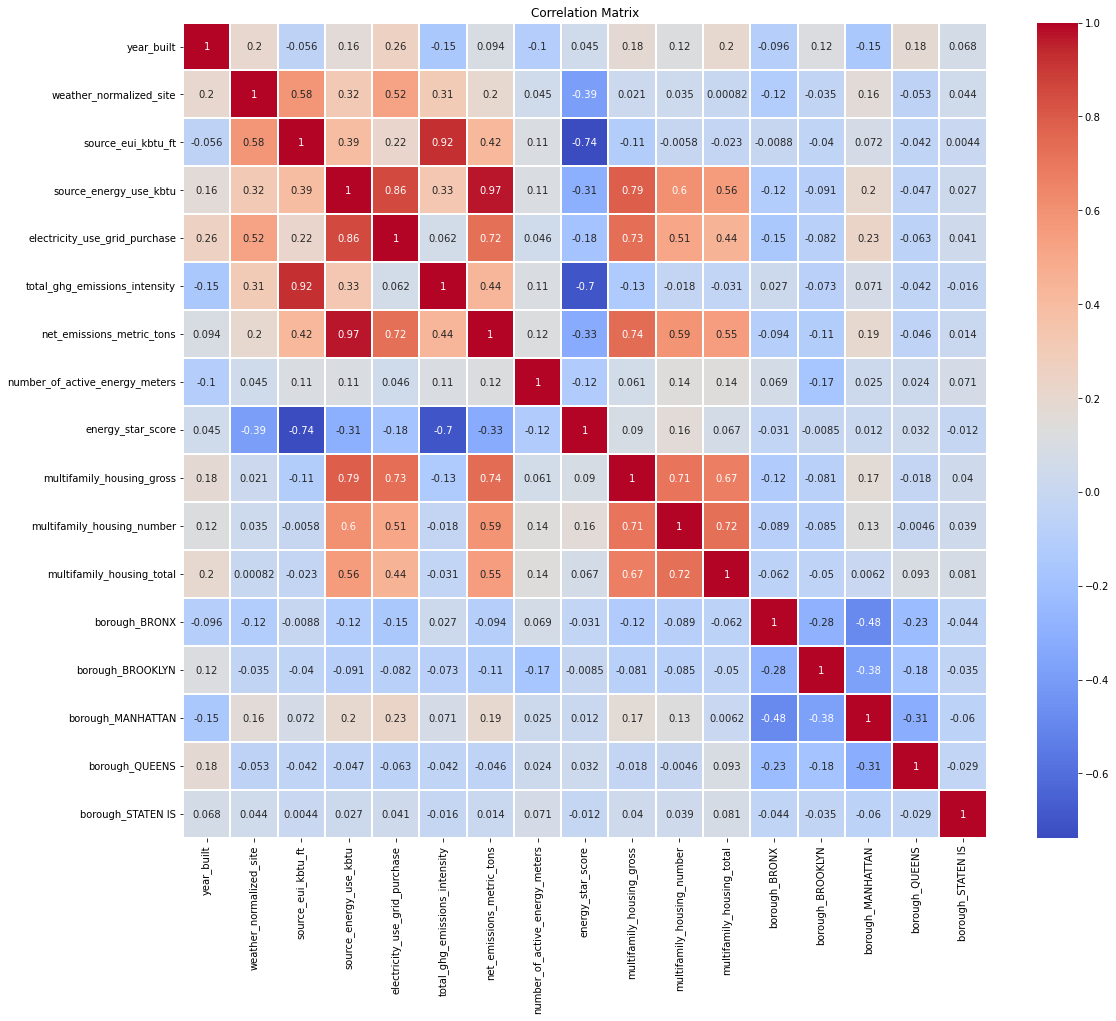

In [22]:
corr_matrix = df3.corr()
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.3)
plt.title("Correlation Matrix")
plt.show()

- **Strong Correlations**: Some pairs of variables exhibit strong positive or negative correlations. Strong correlations (either positive or negative) suggest a significant linear relationship between those variables.  
  
  
- **Energy-Related Metrics**: Variables related to energy use and emissions might be expected to show strong correlations with each other, given their related nature.  
  
  
- **Year and Energy Metrics**: There might be interesting correlations between the year a building was built (year_built) and various energy metrics, reflecting changes in building standards and efficiency over time.  
  
  
- **Boroughs**: The binary indicators for boroughs (like borough_MANHATTAN, borough_QUEENS, etc.) are mutually exclusive, so they will naturally show negative correlations with each other.  

### histograms

##### visualize the distribution of some of these key features using histograms

<AxesSubplot:xlabel='year_built', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of year_built')

Text(0.5, 0, 'year_built')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='weather_normalized_site', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of weather_normalized_site')

Text(0.5, 0, 'weather_normalized_site')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='source_eui_kbtu_ft', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of source_eui_kbtu_ft')

Text(0.5, 0, 'source_eui_kbtu_ft')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='source_energy_use_kbtu', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of source_energy_use_kbtu')

Text(0.5, 0, 'source_energy_use_kbtu')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='electricity_use_grid_purchase', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of electricity_use_grid_purchase')

Text(0.5, 0, 'electricity_use_grid_purchase')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='total_ghg_emissions_intensity', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of total_ghg_emissions_intensity')

Text(0.5, 0, 'total_ghg_emissions_intensity')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='net_emissions_metric_tons', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of net_emissions_metric_tons')

Text(0.5, 0, 'net_emissions_metric_tons')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of energy_star_score')

Text(0.5, 0, 'energy_star_score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_gross', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_gross')

Text(0.5, 0, 'multifamily_housing_gross')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_number', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_number')

Text(0.5, 0, 'multifamily_housing_number')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_total', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_total')

Text(0.5, 0, 'multifamily_housing_total')

Text(0, 0.5, 'Frequency')

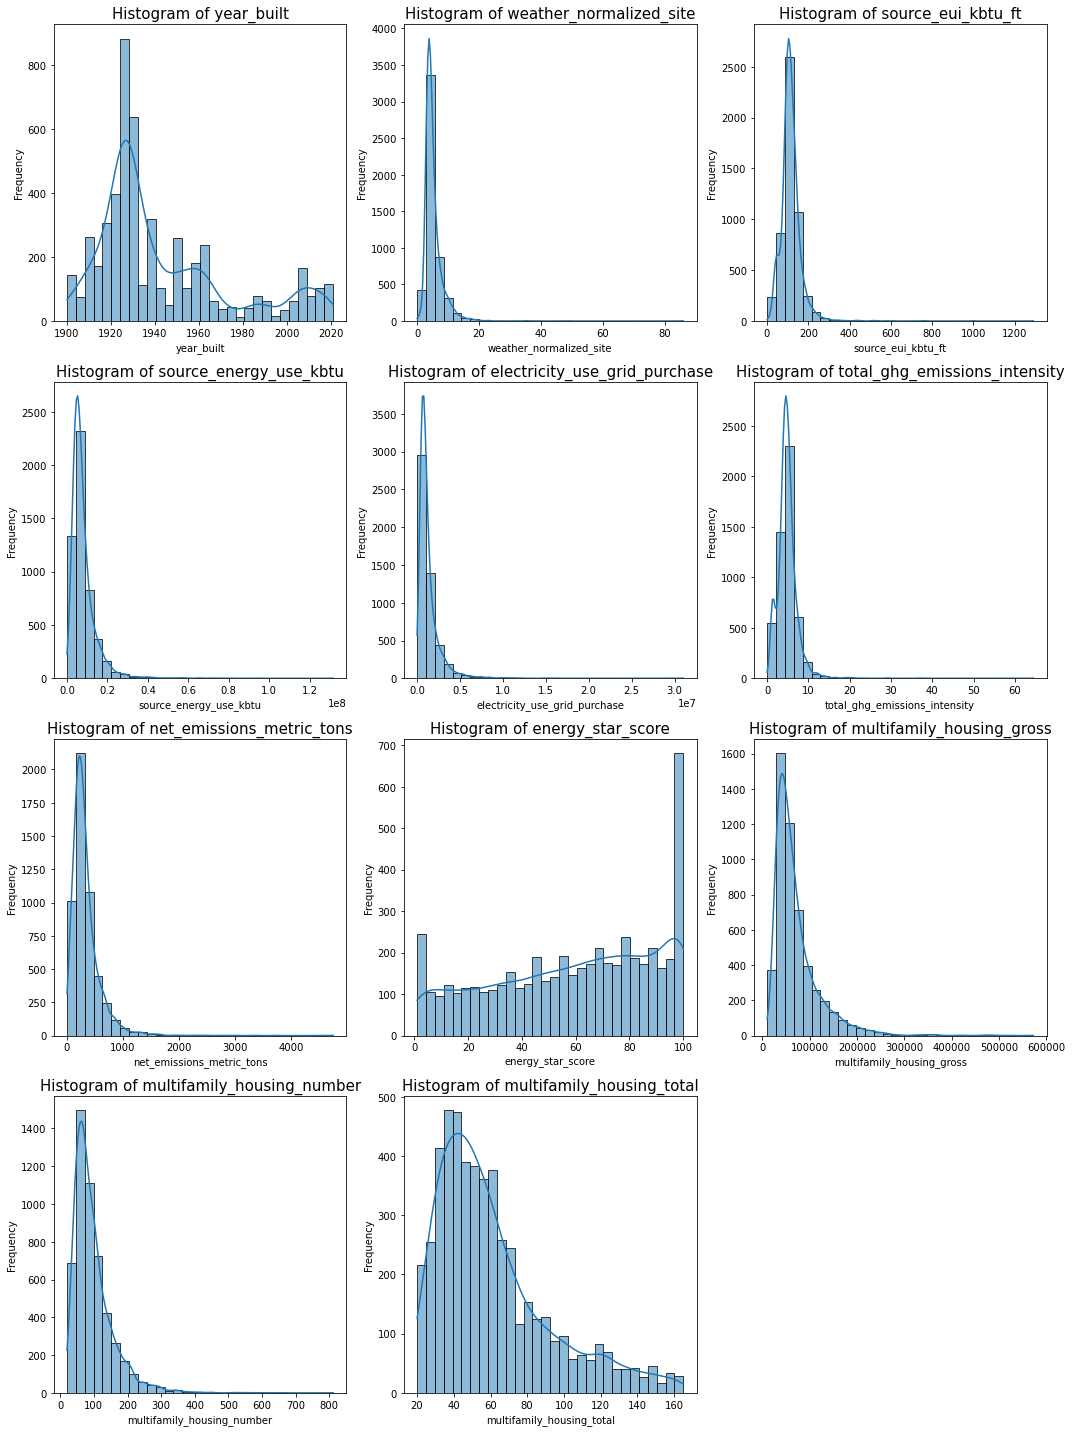

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

numerical_columns = ['year_built', 'weather_normalized_site', 'source_eui_kbtu_ft',
                     'source_energy_use_kbtu', 'electricity_use_grid_purchase',
                     'total_ghg_emissions_intensity', 'net_emissions_metric_tons',
                     'energy_star_score', 'multifamily_housing_gross',
                     'multifamily_housing_number', 'multifamily_housing_total']

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(df3[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Histogram of {col}', fontsize=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for ax in axes[len(numerical_columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1080x720 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:xlabel='source_eui_kbtu_ft', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of source_eui_kbtu_ft')

Text(0.5, 0, 'source_eui_kbtu_ft')

Text(0, 0.5, 'Frequency')

<AxesSubplot:>

<AxesSubplot:xlabel='total_ghg_emissions_intensity', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of total_ghg_emissions_intensity')

Text(0.5, 0, 'total_ghg_emissions_intensity')

Text(0, 0.5, 'Frequency')

<AxesSubplot:>

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Distribution of energy_star_score')

Text(0.5, 0, 'energy_star_score')

Text(0, 0.5, 'Frequency')

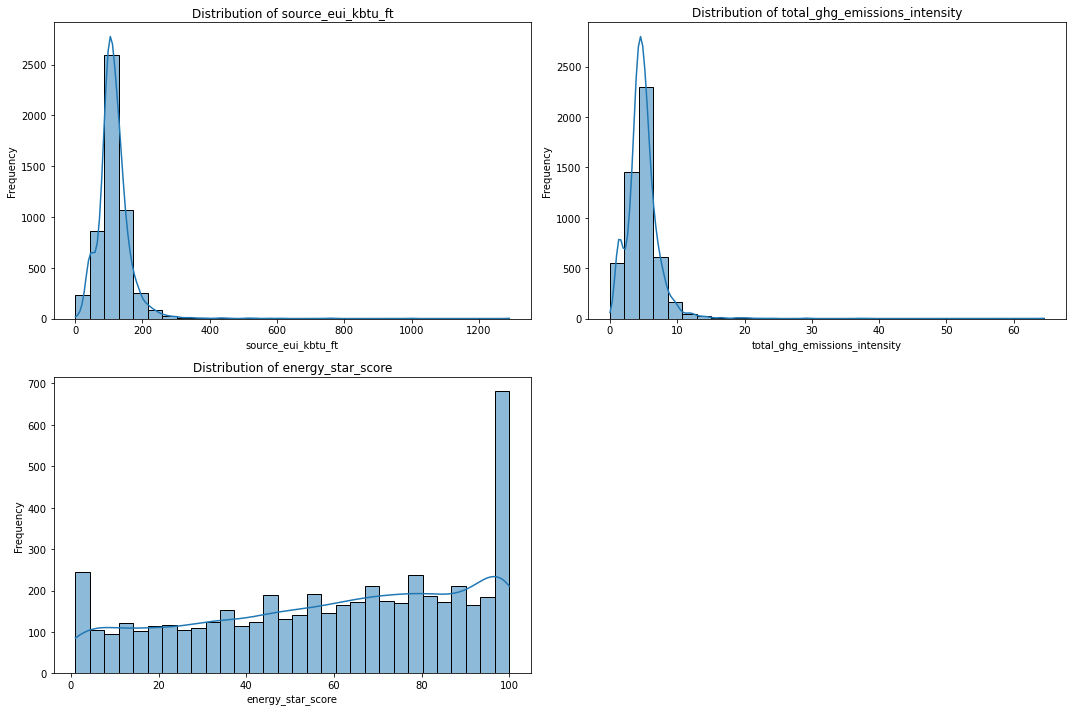

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting a subset of columns for histogram plots
columns_to_plot = ['source_eui_kbtu_ft', 'total_ghg_emissions_intensity', 'energy_star_score']
#'year_built', 

# Setting up the plot
plt.figure(figsize=(15, 10))

# Creating a histogram for each selected column
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df3[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Boxplot for outliers

##### let's examine the dataset for potential outliers.

<Figure size 1080x360 with 0 Axes>

<AxesSubplot:>

<AxesSubplot:ylabel='source_eui_kbtu_ft'>

Text(0.5, 1.0, 'Box Plot of source_eui_kbtu_ft')

<AxesSubplot:>

<AxesSubplot:ylabel='total_ghg_emissions_intensity'>

Text(0.5, 1.0, 'Box Plot of total_ghg_emissions_intensity')

<AxesSubplot:>

<AxesSubplot:ylabel='energy_star_score'>

Text(0.5, 1.0, 'Box Plot of energy_star_score')

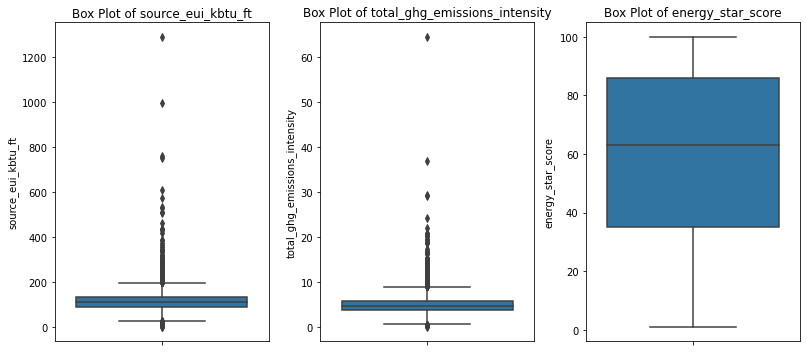

In [25]:
columns_for_outliers = ['source_eui_kbtu_ft', 'total_ghg_emissions_intensity', 'energy_star_score']

plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_for_outliers, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(y=df3[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()


### Right skewed?

To provide a more precise answer, I can calculate the skewness values for each of these columns. A skewness value greater than 0 typically indicates right skewness. Let's calculate these values.

In [26]:
# Calculating the skewness for each numerical column
skewness_values = df3[numerical_columns].skew().sort_values(ascending=False)
skewness_values

weather_normalized_site          7.061990
electricity_use_grid_purchase    5.865480
source_eui_kbtu_ft               5.323319
source_energy_use_kbtu           4.692320
total_ghg_emissions_intensity    4.597995
net_emissions_metric_tons        4.355072
multifamily_housing_gross        2.843914
multifamily_housing_number       2.471589
multifamily_housing_total        1.211868
year_built                       1.137804
energy_star_score               -0.340491
dtype: float64

### Transformation

Considering the nature of your data, I suggest using the Box-Cox transformation for positive values and the Yeo-Johnson transformation for variables that might contain zero or negative values.

In [27]:
# Checking for negative or zero values in the predictor columns

transform_columns = ['year_built', 'weather_normalized_site', 'source_eui_kbtu_ft',
                     'source_energy_use_kbtu', 'electricity_use_grid_purchase',
                     'total_ghg_emissions_intensity', 'net_emissions_metric_tons',
                     'multifamily_housing_gross',
                     'multifamily_housing_number', 'multifamily_housing_total']

predictor_columns = [col for col in transform_columns if col != 'year_built']

negative_or_zero_values = {col: (df3[col] <= 0).any() for col in predictor_columns}

negative_or_zero_values


{'weather_normalized_site': True,
 'source_eui_kbtu_ft': False,
 'source_energy_use_kbtu': False,
 'electricity_use_grid_purchase': True,
 'total_ghg_emissions_intensity': True,
 'net_emissions_metric_tons': False,
 'multifamily_housing_gross': False,
 'multifamily_housing_number': False,
 'multifamily_housing_total': False}

In [28]:
from scipy.stats import yeojohnson, boxcox

# Applying transformations
transformed_data = df3.copy()
for col in predictor_columns:
    # Apply Yeo-Johnson transformation to columns with zero or negative values
    if negative_or_zero_values[col]:
        transformed_data[col], _ = yeojohnson(df3[col])
    # Apply Box-Cox transformation to the rest
    else:
        # Adding a small value to avoid issues with zero values in Box-Cox
        transformed_data[col], _ = boxcox(df3[col] + 1e-5)

# Recalculating the skewness for the transformed predictor columns
new_skewness_values = transformed_data[predictor_columns].skew().sort_values(ascending=False)
new_skewness_values

source_eui_kbtu_ft               0.201772
electricity_use_grid_purchase    0.119991
total_ghg_emissions_intensity    0.077425
net_emissions_metric_tons        0.048419
multifamily_housing_gross        0.029351
source_energy_use_kbtu           0.027786
multifamily_housing_total        0.017933
multifamily_housing_number       0.005518
weather_normalized_site         -0.119675
dtype: float64

The skewness for most of the variables has been substantially reduced, making them more suitable for linear modeling. Notably, the weather_normalized_site column, previously highly skewed, now shows a slight left skew (-0.12) after the transformation and imputation. This is a significant improvement from its original state.

In [29]:
#transformed data is the data been tarnsformed
transformed_data.head()

,year_built,weather_normalized_site,source_eui_kbtu_ft,source_energy_use_kbtu,electricity_use_grid_purchase,total_ghg_emissions_intensity,net_emissions_metric_tons,number_of_active_energy_meters,energy_star_score,multifamily_housing_gross,multifamily_housing_number,multifamily_housing_total,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN IS
0,2010,1.418879,11.201858,25.717762,19.512834,2.087182,7.269858,8,71,2.513349,2.566288,2.377937,0,0,0,1,0
4,1941,1.303623,12.672037,29.671362,21.131671,2.692026,11.200368,11,24,2.530124,3.148468,3.000745,0,0,1,0,0
5,1982,1.303623,11.830082,30.100812,21.718308,2.410401,11.560079,11,57,2.533830,3.391650,2.786748,0,0,1,0,0
6,1983,1.344972,12.309220,30.076355,21.823920,2.532068,11.503850,14,54,2.532622,3.403550,2.728608,0,0,1,0,0
7,1958,1.259177,12.709055,28.717194,20.240701,2.713988,10.319457,8,42,2.525712,3.271791,2.670584,0,0,1,0,0


Histogram after transformation

<AxesSubplot:xlabel='year_built', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of year_built')

Text(0.5, 0, 'year_built')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='weather_normalized_site', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of weather_normalized_site')

Text(0.5, 0, 'weather_normalized_site')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='source_eui_kbtu_ft', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of source_eui_kbtu_ft')

Text(0.5, 0, 'source_eui_kbtu_ft')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='source_energy_use_kbtu', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of source_energy_use_kbtu')

Text(0.5, 0, 'source_energy_use_kbtu')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='electricity_use_grid_purchase', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of electricity_use_grid_purchase')

Text(0.5, 0, 'electricity_use_grid_purchase')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='total_ghg_emissions_intensity', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of total_ghg_emissions_intensity')

Text(0.5, 0, 'total_ghg_emissions_intensity')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='net_emissions_metric_tons', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of net_emissions_metric_tons')

Text(0.5, 0, 'net_emissions_metric_tons')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of energy_star_score')

Text(0.5, 0, 'energy_star_score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_gross', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_gross')

Text(0.5, 0, 'multifamily_housing_gross')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_number', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_number')

Text(0.5, 0, 'multifamily_housing_number')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='multifamily_housing_total', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of multifamily_housing_total')

Text(0.5, 0, 'multifamily_housing_total')

Text(0, 0.5, 'Frequency')

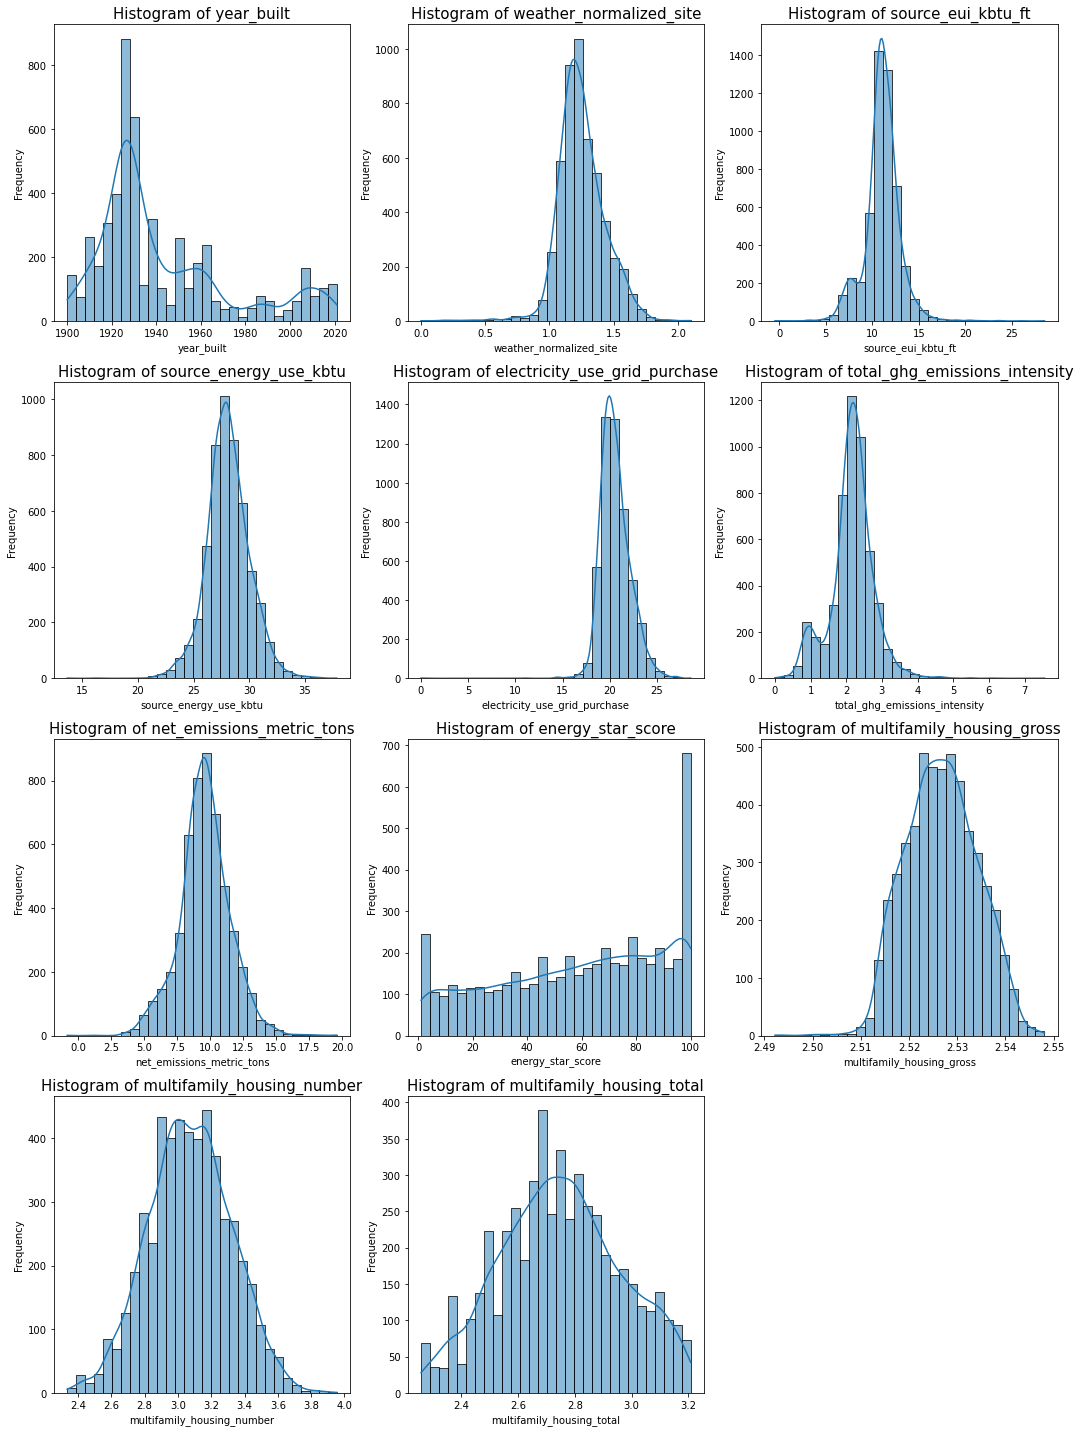

In [30]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))

numerical_columns = ['year_built', 'weather_normalized_site', 'source_eui_kbtu_ft',
                     'source_energy_use_kbtu', 'electricity_use_grid_purchase',
                     'total_ghg_emissions_intensity', 'net_emissions_metric_tons',
                     'energy_star_score', 'multifamily_housing_gross',
                     'multifamily_housing_number', 'multifamily_housing_total']

axes = axes.flatten()

for i, col in enumerate(numerical_columns):
    sns.histplot(transformed_data[col], ax=axes[i], kde=True, bins=30)
    axes[i].set_title(f'Histogram of {col}', fontsize=15)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

for ax in axes[len(numerical_columns):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

## y distributions

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Original')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Log Transformation')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Square Root Transformation')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Inverse Transformation')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:ylabel='Count'>

Text(0.5, 1.0, 'Box-Cox Transformation')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Cube Root Transformation')

Text(0.5, 0, 'Transformed Energy Star Score')

Text(0, 0.5, 'Frequency')

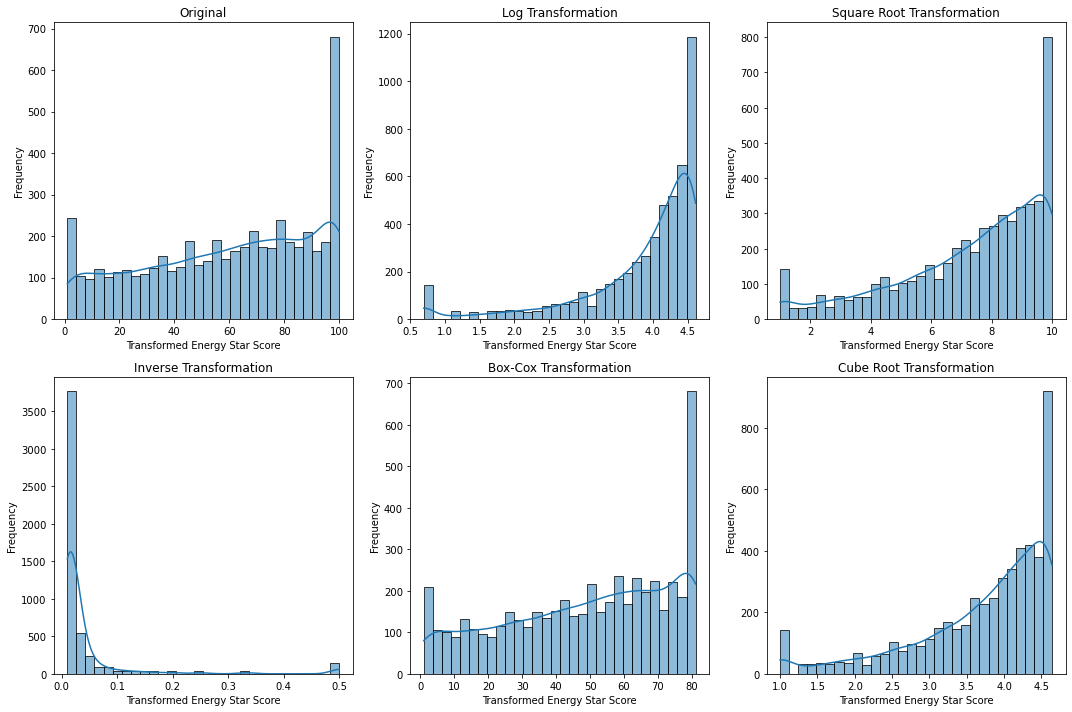

In [31]:
energy_star_scores=transformed_data['energy_star_score']

# Apply various transformations
transformed_log = np.log1p(energy_star_scores)  # Log transformation
transformed_sqrt = np.sqrt(energy_star_scores)  # Square root transformation
transformed_inv = 1 / (energy_star_scores + 1)  # Inverse transformation

# Box-Cox transformation
transformed_boxcox, _ = stats.boxcox(energy_star_scores + 1)

# Cube root transformation
transformed_cbrt = np.cbrt(energy_star_scores)

transformations = {
    'original': energy_star_scores,
    'log': transformed_log,
    'sqrt': transformed_sqrt,
    'inverse': transformed_inv,
    'boxcox': transformed_boxcox,
    'cbrt': transformed_cbrt
}

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

transform_list = [
    ('original', 'Original'),
    ('log', 'Log Transformation'),
    ('sqrt', 'Square Root Transformation'),
    ('inverse', 'Inverse Transformation'),
    ('boxcox', 'Box-Cox Transformation'),
    ('cbrt', 'Cube Root Transformation')
]

for ax, (transform_key, title) in zip(axes.flatten(), transform_list):
    sns.histplot(transformations[transform_key], kde=True, bins=30, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Transformed Energy Star Score')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [32]:
for key, transformation in transformations.items():
    if not isinstance(transformation, pd.Series):
        transformations[key] = pd.Series(transformation)

# Calculate skewness for each transformation
skewness_scores = {key: transformations[key].skew() for key in transformations}
skewness_df = pd.DataFrame(list(skewness_scores.items()), columns=['Transformation', 'Skewness'])

skewness_df

,Transformation,Skewness
0,original,-0.340491
1,log,-1.847656
2,sqrt,-0.942105
3,inverse,4.310233
4,boxcox,-0.391516
5,cbrt,-1.249021


## Model

In [33]:
#X and y here are original data for X and y
y = df3['energy_star_score']
X = df3.drop(columns = 'energy_star_score')

X0_train, X0_test, y0_train, y0_test = train_test_split(X, y, test_size=0.2, random_state=42)

#X2 y2 are the data after transformations
y2 = transformed_data['energy_star_score']
X2 = transformed_data.drop(columns = 'energy_star_score')

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model_adjr2_results={}
model_mse_results={}

In [34]:
# df4=transformed_data
# transformed_boxcox, _ = stats.boxcox(transformed_data['energy_star_score'] + 1)
# df4['energy_star_score']=transformed_boxcox

# #X2 y2 are the data after transformations
# y2 = df4['energy_star_score']
# X2 = df4.drop(columns = 'energy_star_score')

# X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

## OLS

In [35]:
lr = LinearRegression()

lr.fit(X0_train, y0_train)
y_pred = lr.predict(X0_test)

r2 = r2_score(y0_test, y_pred)
mse = mean_squared_error(y0_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

model_adjr2_results['Full Regression Untransformed']=r2
model_mse_results['Full Regression Untransformed']=mse

LinearRegression()

R-squared: 0.6754708091472847
Mean Squared Error: 293.8435758625867


## OLS Transformed

In [36]:
lr = LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

model_adjr2_results['Full Regression Transformed']=r2
model_mse_results['Full Regression Transformed']=mse

LinearRegression()

R-squared: 0.7671723306132332
Mean Squared Error: 210.81282319348946


<AxesSubplot:ylabel='energy_star_score'>

Text(0.5, 1.0, 'Residuals vs Predictions')

Text(0.5, 0, 'Predicted values')

Text(0, 0.5, 'Residuals')

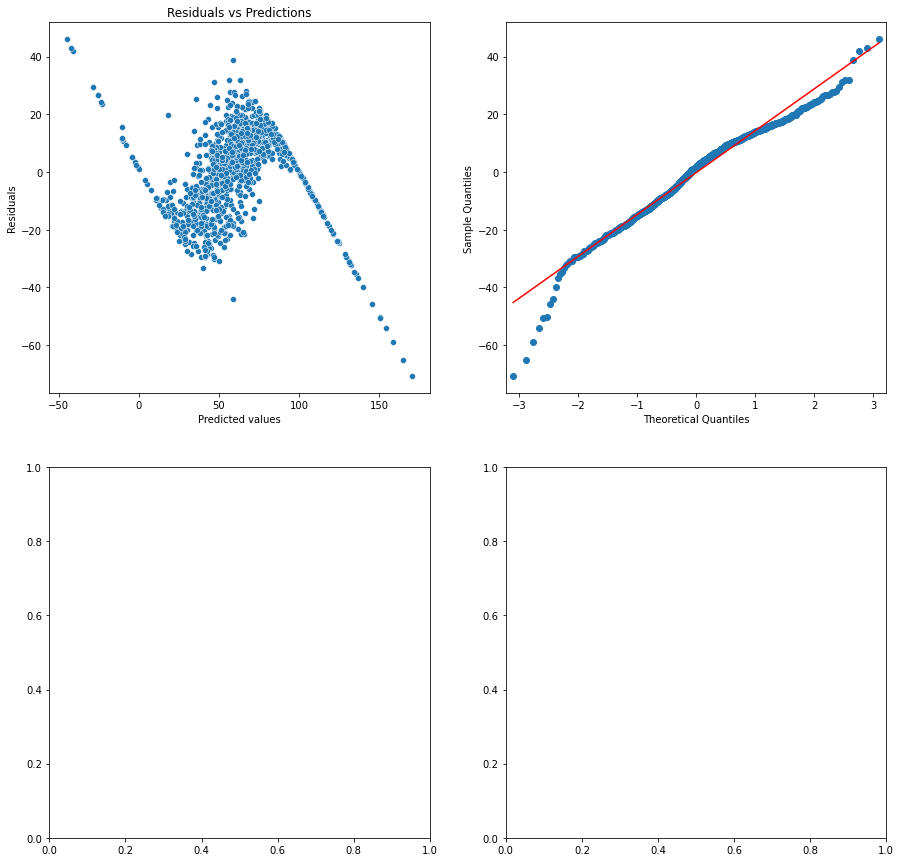

Text(0.5, 1.0, 'QQ Plot of Residuals')

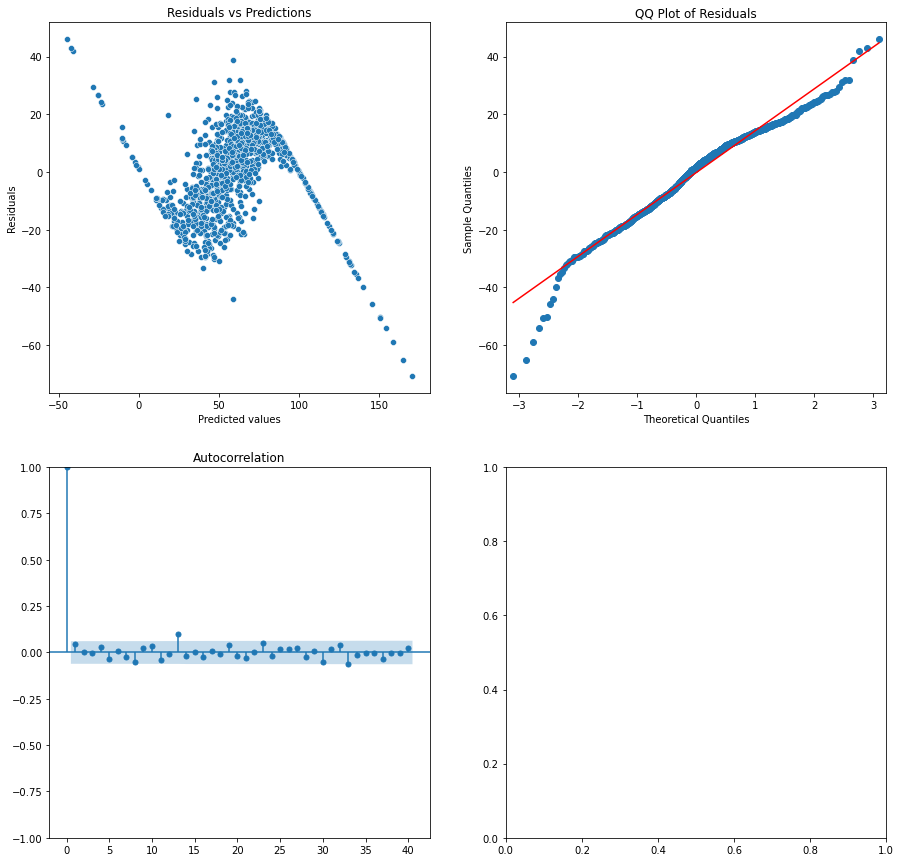

Text(0.5, 1.0, 'ACF Plot of Residuals')

<AxesSubplot:xlabel='energy_star_score', ylabel='Count'>

Text(0.5, 1.0, 'Histogram of Residuals')

Text(0.5, 3.200000000000017, 'Residuals')

Text(478.8704545454544, 0.5, 'Frequency')

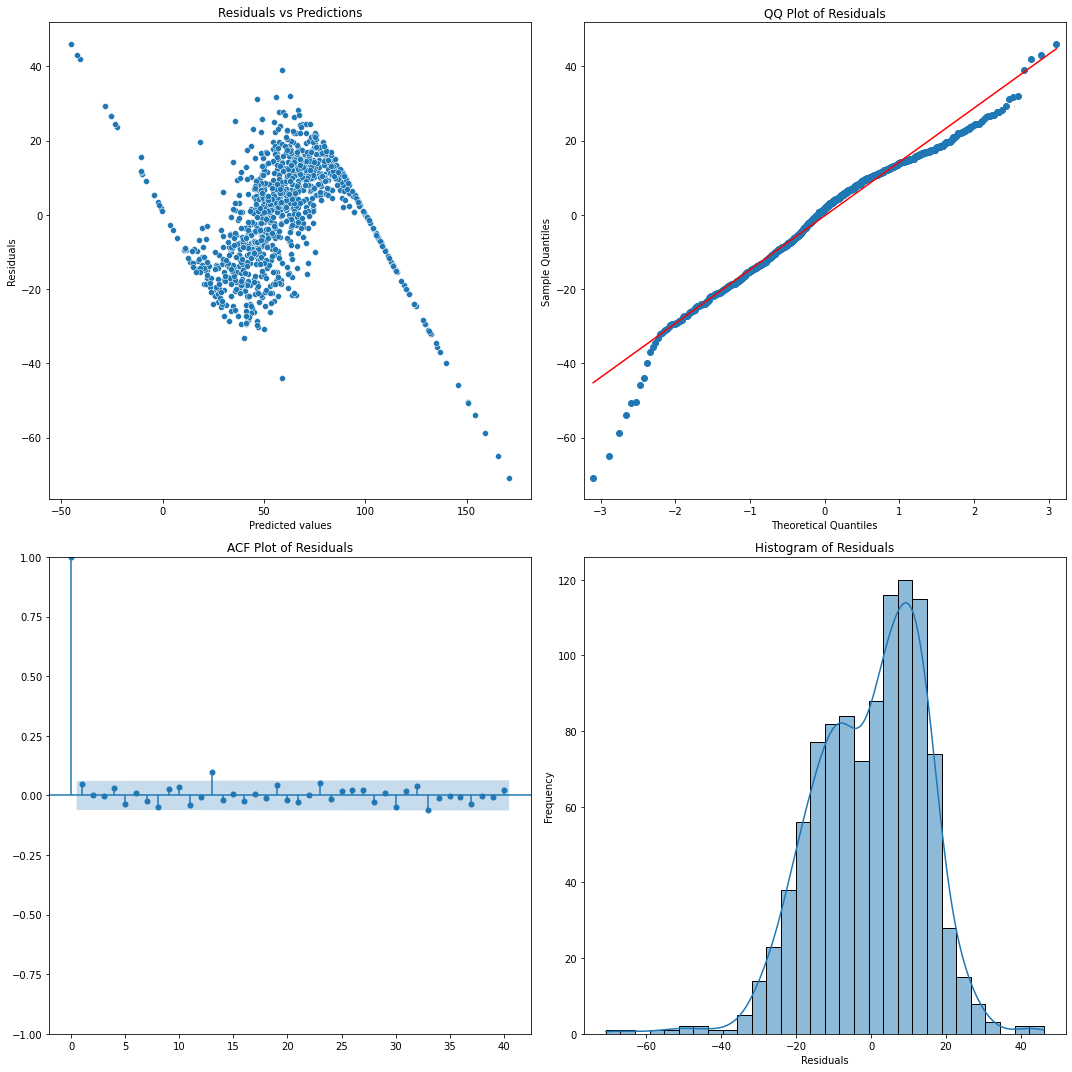

In [37]:
residuals = y_test - y_pred

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

# Residuals vs Predictions
sns.scatterplot(x=y_pred, y=residuals, ax=axs[0, 0])
axs[0, 0].set_title('Residuals vs Predictions')
axs[0, 0].set_xlabel('Predicted values')
axs[0, 0].set_ylabel('Residuals')

# QQ plot of residuals
sm.qqplot(residuals, line='s', ax=axs[0, 1])
axs[0, 1].set_title('QQ Plot of Residuals')

# ACF plot of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40, ax=axs[1, 0])
axs[1, 0].set_title('ACF Plot of Residuals')

# Histogram of residuals
sns.histplot(residuals, kde=True, bins=30, ax=axs[1, 1])
axs[1, 1].set_title('Histogram of Residuals')
axs[1, 1].set_xlabel('Residuals')
axs[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Fitted values')

Text(0, 0.5, 'Residuals')

Text(0.5, 1.0, 'Residuals vs. Fitted')

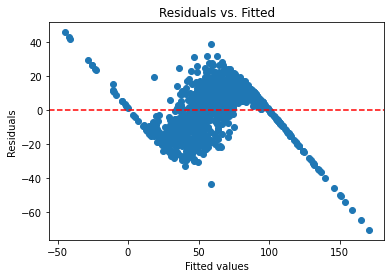

In [38]:
# Residuals vs Fitted
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

In [39]:
XLR = sm.add_constant(X_train)
LR0 = sm.OLS(y_train, XLR).fit()
LR0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_star_score   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     839.7
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:25:32   Log-Likelihood:                -16969.
No. Observations:                4128   AIC:                         3.397e+04
Df Residuals:                    4111   BIC:                         3.408e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           3644.4342    413.238      8.819      0.000    2834.264    4454.605
year_built                         0.0154      0.009      1.777      0.076      -0.002       0.032
weather_normalized_site          -35.4729      4.892     -7.251      0.000     -45.064     -25.882
source_eui_kbtu_ft                -1.1937      1.510     -0.791      0.429      -4.153       1.766
source_energy_use_kbtu           -15.5419      2.488     -6.247      0.000     -20.420     -10.664
electricity_use_grid_purchase      4.0989      0.902      4.546      0.000       2.331       5.867
total_ghg_emissions_intensity    -37.3668      4.381     -8.529      0.000     -45.956     -28.777
net_emissions_metric_tons         13.8272      2.102      6.579      0.000       9.707      17.948
number_of_active_energy_meters    -0.2259      0.033     -6.940      0.000      -0.290      -0.162
multifamily_housing_gross      -1350.0961    173.369     -7.787      0.000   -1689.993   -1010.199
multifamily_housing_number        58.2093      1.588     36.650      0.000      55.096      61.323
multifamily_housing_total         -8.8080      1.832     -4.809      0.000     -12.399      -5.217
borough_BRONX                      0.5733      1.688      0.340      0.734      -2.736       3.882
borough_BROOKLYN                  -1.3302      1.721     -0.773      0.440      -4.704       2.044
borough_MANHATTAN                  3.3159      1.672      1.984      0.047       0.039       6.593
borough_QUEENS                     1.8862      1.745      1.081      0.280      -1.535       5.308
borough_STATEN IS                 -0.9383      3.436     -0.273      0.785      -7.674       5.797
==============================================================================
Omnibus:                      542.899   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6392.079
Skew:                          -0.126   Prob(JB):                         0.00
Kurtosis:                       9.091   Cond. No.                     3.78e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
#XLR = sm.add_constant(X0_train)
#LR0 = sm.OLS(y0_train, XLR).fit()
#LR0.summary()
# print('With intercept term within regression, we have a R2 of ')
# LR0.rsquared_adj

In [41]:
# model = LinearRegression()
# model.fit(X_train, y_train)

# y_train_pred = model.predict(X_train)
# residuals = y_train - y_train_pred

# variable_names = X_train.columns
# titles = [f'Residuals vs {var}' for var in variable_names]

# fig, axes = plt.subplots(4, 4, figsize=(20, 20))

# for ax, title in zip(axes.flatten(), titles):
#     var_index = titles.index(title)
#     sns.scatterplot(x=X_train.iloc[:, var_index], y=residuals, ax=ax)
#     ax.set_title(title)
#     ax.set_xlabel(variable_names[var_index])
#     ax.set_ylabel('Residuals')

# plt.tight_layout()
# plt.show()

**Ridge**

In [42]:
from sklearn.linear_model import RidgeCV

alphas = [0.01, 0.05, 0.1,0.5, 1.0, 10.0]
ridge_cv = RidgeCV(alphas=alphas, cv=5)


ridge_cv.fit(X_train, y_train)
best_alpha = ridge_cv.alpha_


ridge_model = Ridge(alpha=best_alpha)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

model_adjr2_results['Ridge'] = r2
model_mse_results['Ridge'] = mse

print(f'Best Alpha: {best_alpha}')
print(f'R-squared_adj: {r2}')
print(f'Mean Squared Error: {mse}')

RidgeCV(alphas=array([ 0.01,  0.05,  0.1 ,  0.5 ,  1.  , 10.  ]), cv=5)

Ridge(alpha=0.01)

Best Alpha: 0.01
R-squared_adj: 0.7638531761719999
Mean Squared Error: 213.81813746826862


<Figure size 720x432 with 0 Axes>

Text(0.01, 213.81813746826862, 'Best alpha: 0.01000')

Text(0.5, 0, 'Alpha')

Text(0, 0.5, 'Mean Squared Error')

Text(0.5, 1.0, 'Ridge: Alpha vs. Mean Squared Error (Updated)')

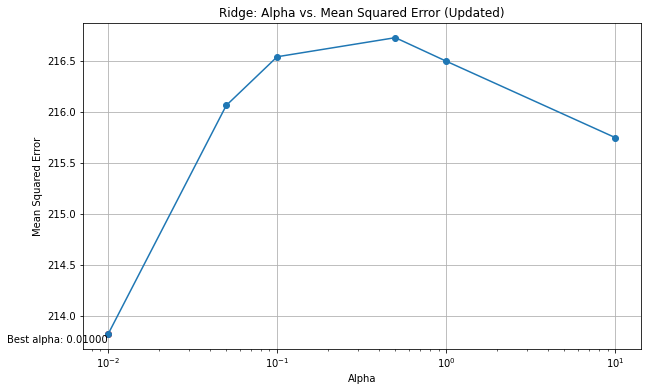

0.01

In [43]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

def calculate_mse_for_alphas(alphas, X_train, y_train, X_test, y_test):
    mse_list = []
    for alpha in alphas:
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train, y_train)
        y_pred = ridge_model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_list.append(mse)
    return mse_list


alphas_updated = [0.01, 0.05, 0.1, 0.5, 1.0, 10.0]
ridge_mse_values_updated = calculate_mse_for_alphas(alphas_updated, X_train, y_train, X_test, y_test)
best_alpha_updated = ridge_cv.alpha_

plt.figure(figsize=(10, 6))
plt.plot(alphas_updated, ridge_mse_values_updated, marker='o')
plt.scatter(best_alpha_updated, min(ridge_mse_values_updated), color='red')
plt.text(best_alpha_updated, min(ridge_mse_values_updated), f'Best alpha: {best_alpha_updated:.5f}', 
         verticalalignment='top', horizontalalignment='right')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Ridge: Alpha vs. Mean Squared Error (Updated)')
plt.xscale('log')
plt.grid(True)
plt.show()

best_alpha_updated

In [48]:
ridge_coefficients = ridge_model.coef_
variable_names = X_train.columns.tolist()
variable_coefficient_dict = dict(zip(variable_names, ridge_coefficients))

ridge_df= pd.DataFrame.from_dict(variable_coefficient_dict, orient='index', columns=['Ridge_coefficients'])
ridge_df=ridge_df.reindex(ridge_df['Ridge_coefficients'].abs().sort_values(ascending=False).index)

ridge_df

,Ridge_coefficients
multifamily_housing_gross,-568.857176
multifamily_housing_number,57.850389
total_ghg_emissions_intensity,-43.818591
weather_normalized_site,-32.128679
source_energy_use_kbtu,-21.560042
net_emissions_metric_tons,17.077785
multifamily_housing_total,-10.190155
electricity_use_grid_purchase,3.740516
borough_MANHATTAN,3.367479
source_eui_kbtu_ft,2.498841


## LASSO

In [49]:
lasso_cv = LassoCV(cv=5) 
lasso_cv.fit(X_train, y_train)

best_alpha = lasso_cv.alpha_

lasso_model = Lasso(alpha=best_alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'Best Alpha: {best_alpha}')
print(f'R-squared_adj: {r2}')
print(f'Mean Squared Error: {mse}')

model_adjr2_results['Lasso Transformed']=r2
model_mse_results['Lasso Transformed']=mse

C:\Users\15045\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 343.5985266752541, tolerance: 306.59555791704514
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\15045\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 340.1404496190371, tolerance: 306.59555791704514
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\15045\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 332.43961001723073, tolerance: 306.59555791704514
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\15045\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:633

LassoCV(cv=5)

C:\Users\15045\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e+03, tolerance: 3.837e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.04712096670553455)

Best Alpha: 0.04712096670553455
R-squared_adj: 0.7608761083143419
Mean Squared Error: 216.5137109006037


<Figure size 720x432 with 0 Axes>

Text(0.5, 0, 'Alpha')

Text(0, 0.5, 'Mean Squared Error')

Text(0.5, 1.0, 'Alpha vs. Mean Squared Error')

Text(0.04712096670553455, 230.51135651389555, ' Best alpha: 0.04712')

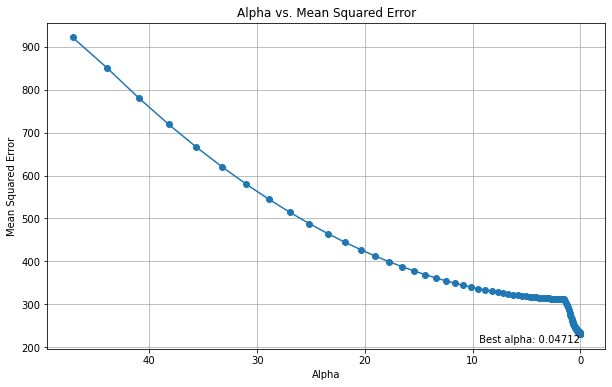

In [50]:
mse_values = lasso_cv.mse_path_.mean(axis=1)
alphas = lasso_cv.alphas_

plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_values, marker='o')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('Alpha vs. Mean Squared Error')

plt.scatter(best_alpha, min(mse_values), color='red')
plt.text(best_alpha, min(mse_values), f' Best alpha: {best_alpha:.5f}', 
         verticalalignment='top', horizontalalignment='right')

plt.gca().invert_xaxis()  
plt.grid(True)
plt.show()

In [51]:
lasso_coefficients = lasso_model.coef_
variable_names = X.columns.tolist()

variable_coefficient_dict = dict(zip(variable_names, lasso_coefficients))

lasso_df= pd.DataFrame.from_dict(variable_coefficient_dict, orient='index', columns=['Lasso_coefficients'])
lasso_df=lasso_df.reindex(lasso_df['Lasso_coefficients'].abs().sort_values(ascending=False).index)

new_list=lasso_df[lasso_df['Lasso_coefficients']!=0].index.tolist()
lasso_df

,Lasso_coefficients
multifamily_housing_number,53.774012
total_ghg_emissions_intensity,-21.955554
source_energy_use_kbtu,-11.692631
multifamily_housing_total,-8.262796
weather_normalized_site,-8.111101
net_emissions_metric_tons,7.177412
source_eui_kbtu_ft,-3.875526
borough_MANHATTAN,3.090924
borough_BROOKLYN,-1.661907
borough_QUEENS,0.991773


## PCA

In [52]:
scaler = StandardScaler()
dataX = scaler.fit_transform(X_train)

pca = PCA()
pca.fit(dataX)

eigenvalues = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_

table_data = {
    "PC": [f"PC{i + 1}" for i in range(dataX.shape[1])],
    "Eigenvalue": eigenvalues,
    "Explained Variance": explained_variance_ratio,
    'Cumulative Explained Variance': np.cumsum(explained_variance_ratio)
}

layer0_summary=pd.DataFrame(table_data)
layer0_summary

PCA()

,PC,Eigenvalue,Explained Variance,Cumulative Explained Variance
0,PC1,4.907420,0.306639,0.306639
1,PC2,2.446113,0.152845,0.459484
2,PC3,1.575430,0.098441,0.557925
3,PC4,1.512371,0.094500,0.652425
4,PC5,1.219278,0.076186,0.728612
5,PC6,1.164806,0.072783,0.801394
6,PC7,1.010617,0.063148,0.864543
7,PC8,0.861802,0.053850,0.918392
8,PC9,0.565973,0.035365,0.953757
9,PC10,0.405406,0.025332,0.979089


<Figure size 576x360 with 0 Axes>

C:\Users\15045\AppData\Local\Temp\ipykernel_11476\1502766890.py:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-', linestyle='--', markerfacecolor='white')


Text(0.5, 1.0, 'Scree Plot')

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Proportion of Variance Explained')

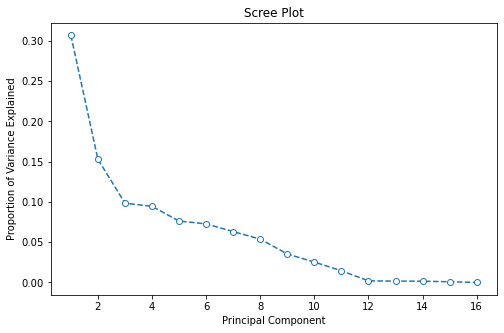

In [53]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance_ratio)+1), explained_variance_ratio, 'o-', linestyle='--', markerfacecolor='white')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

<Figure size 576x360 with 0 Axes>

C:\Users\15045\AppData\Local\Temp\ipykernel_11476\3441441622.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-', linestyle='--', markerfacecolor='white')


Text(0.5, 1.0, 'Scree Plot')

Text(0.5, 0, 'Principal Component')

Text(0, 0.5, 'Cumulative Variance Explained')

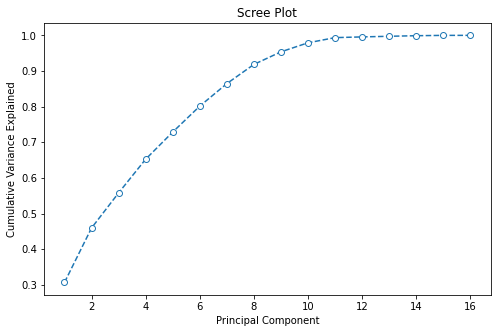

In [54]:
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'o-', linestyle='--', markerfacecolor='white')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.show()

In [55]:
#Change the number of n_components here to see different loading structure
n_components=4
factor_loadings=pca.components_[:n_components].T
rotator = Rotator(method='varimax')
rotated_loadings = rotator.fit_transform(factor_loadings)
layer0_loadings=pd.DataFrame(rotated_loadings, columns=[f'PC{i + 1}' for i in range(n_components)], index=X.columns.to_list())

layer0_loadings = layer0_loadings.apply(lambda row: row.where(abs(row) == abs(row).max()), axis=1)
layer0_loadings

,PC1,PC2,PC3,PC4
year_built,NaN,NaN,NaN,0.524503
weather_normalized_site,NaN,NaN,-0.419661,NaN
source_eui_kbtu_ft,NaN,0.596027,NaN,NaN
source_energy_use_kbtu,-0.347992,NaN,NaN,NaN
electricity_use_grid_purchase,-0.322393,NaN,NaN,NaN
total_ghg_emissions_intensity,NaN,0.577386,NaN,NaN
net_emissions_metric_tons,-0.326988,NaN,NaN,NaN
number_of_active_energy_meters,NaN,NaN,0.186546,NaN
multifamily_housing_gross,-0.481773,NaN,NaN,NaN
multifamily_housing_number,-0.438558,NaN,NaN,NaN


In [56]:
n_components = 9
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared_adj: {r2}')
print(f'Mean Squared Error: {mse}')

model_adjr2_results['PCR']=r2
model_mse_results['PCR']=mse

LinearRegression()

R-squared_adj: 0.7140688219562819
Mean Squared Error: 258.8951692949537


In [57]:
XLR = sm.add_constant(X_train_pca)
LR0 = sm.OLS(y_train, XLR).fit()
LR0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      energy_star_score   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     995.9
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        18:29:03   Log-Likelihood:                -17578.
No. Observations:                4128   AIC:                         3.518e+04
Df Residuals:                    4118   BIC:                         3.524e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         59.3295      0.267    222.572      0.000      58.807      59.852
x1             0.0354      0.009      4.035      0.000       0.018       0.053
x2            -0.5541      0.036    -15.335      0.000      -0.625      -0.483
x3             5.3092      0.085     62.539      0.000       5.143       5.476
x4           -10.9861      0.165    -66.670      0.000     -11.309     -10.663
x5             3.8161      0.305     12.516      0.000       3.218       4.414
x6             3.6726      0.487      7.544      0.000       2.718       4.627
x7            -2.6018      0.592     -4.392      0.000      -3.763      -1.441
x8             0.9808      0.704      1.393      0.164      -0.400       2.362
x9            13.9136      1.264     11.007      0.000      11.435      16.392
==============================================================================
Omnibus:                      396.988   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2652.998
Skew:                           0.174   Prob(JB):                         0.00
Kurtosis:                       6.912   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**KNN Regression**

In [58]:
scaler = StandardScaler()
KNNRX_train = scaler.fit_transform(X_train)

scaler = StandardScaler()
KNNRX_test = scaler.fit_transform(X_test)
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(KNNRX_train, y_train)

y_pred = knn_reg.predict(KNNRX_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse
r2

model_adjr2_results['KNNR']=r2
model_mse_results['KNNR']=mse

KNeighborsRegressor()

127.84732558139535

0.85880178254087

In [59]:
plot_data = transformed_data

<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of 2 Features with Energy Star Score')

Text(0.5, 0, 'source_eui_kbtu_ft')

Text(0, 0.5, 'multifamily_housing_number')

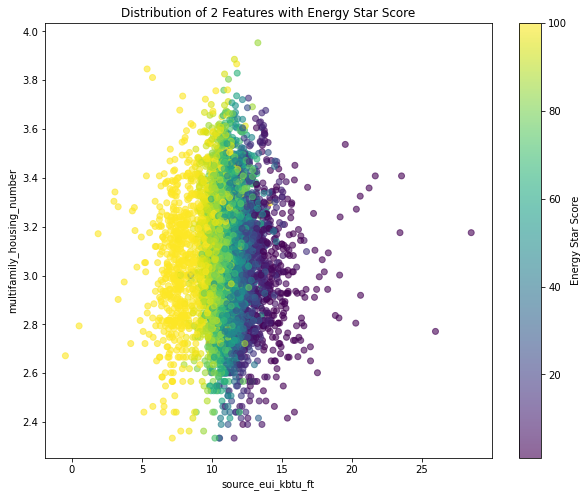

In [60]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(plot_data['source_eui_kbtu_ft'], plot_data['multifamily_housing_number'], 
                      c=plot_data['energy_star_score'], cmap='viridis', alpha=0.6)

plt.title('Distribution of 2 Features with Energy Star Score')
plt.xlabel('source_eui_kbtu_ft')
plt.ylabel('multifamily_housing_number')
plt.colorbar(scatter, label='Energy Star Score')
plt.show()

In [61]:
plot_columns = ['year_built', 'weather_normalized_site',
                     'source_energy_use_kbtu', 'electricity_use_grid_purchase',
                     'total_ghg_emissions_intensity', 'net_emissions_metric_tons',
                     'multifamily_housing_gross',
                     'multifamily_housing_number', 'multifamily_housing_total']

KNeighborsRegressor(metric='euclidean', n_neighbors=1)

KNeighborsRegressor(metric='euclidean', n_neighbors=2)

KNeighborsRegressor(metric='euclidean', n_neighbors=3)

KNeighborsRegressor(metric='euclidean', n_neighbors=4)

KNeighborsRegressor(metric='euclidean')

KNeighborsRegressor(metric='euclidean', n_neighbors=6)

KNeighborsRegressor(metric='euclidean', n_neighbors=7)

KNeighborsRegressor(metric='euclidean', n_neighbors=8)

KNeighborsRegressor(metric='euclidean', n_neighbors=9)

KNeighborsRegressor(metric='euclidean', n_neighbors=10)

KNeighborsRegressor(metric='euclidean', n_neighbors=11)

KNeighborsRegressor(metric='manhattan', n_neighbors=1)

KNeighborsRegressor(metric='manhattan', n_neighbors=2)

KNeighborsRegressor(metric='manhattan', n_neighbors=3)

KNeighborsRegressor(metric='manhattan', n_neighbors=4)

KNeighborsRegressor(metric='manhattan')

KNeighborsRegressor(metric='manhattan', n_neighbors=6)

KNeighborsRegressor(metric='manhattan', n_neighbors=7)

KNeighborsRegressor(metric='manhattan', n_neighbors=8)

KNeighborsRegressor(metric='manhattan', n_neighbors=9)

KNeighborsRegressor(metric='manhattan', n_neighbors=10)

KNeighborsRegressor(metric='manhattan', n_neighbors=11)

KNeighborsRegressor(metric='chebyshev', n_neighbors=1)

KNeighborsRegressor(metric='chebyshev', n_neighbors=2)

KNeighborsRegressor(metric='chebyshev', n_neighbors=3)

KNeighborsRegressor(metric='chebyshev', n_neighbors=4)

KNeighborsRegressor(metric='chebyshev')

KNeighborsRegressor(metric='chebyshev', n_neighbors=6)

KNeighborsRegressor(metric='chebyshev', n_neighbors=7)

KNeighborsRegressor(metric='chebyshev', n_neighbors=8)

KNeighborsRegressor(metric='chebyshev', n_neighbors=9)

KNeighborsRegressor(metric='chebyshev', n_neighbors=10)

KNeighborsRegressor(metric='chebyshev', n_neighbors=11)

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'KNN Regression Performance for Different K and Distance Metrics')

Text(0.5, 0, 'Number of Neighbors (K)')

Text(0, 0.5, 'Mean Squared Error (MSE)')

([<matplotlib.axis.XTick at 0x1d9b41db100>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([100., 125., 150., 175., 200., 225., 250., 275., 300.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

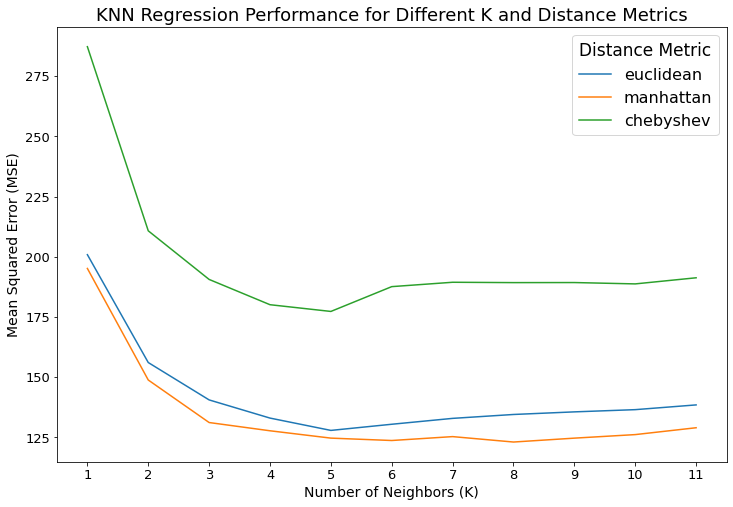

In [62]:
from sklearn.neighbors import DistanceMetric

k_values = range(1, 12)
distance_metrics = ['euclidean', 'manhattan', 'chebyshev']

scaler = StandardScaler()
KNNRX_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
KNNRX_test = scaler.fit_transform(X_test)

mse_results = {metric: [] for metric in distance_metrics}

for metric in distance_metrics:
    for k in k_values:
        knn_regressor = KNeighborsRegressor(n_neighbors=k, metric=metric)
        knn_regressor.fit(KNNRX_train, y_train)
        y_pred = knn_regressor.predict(KNNRX_test)
        mse = mean_squared_error(y_test, y_pred)
        mse_results[metric].append(mse)

mse_df = pd.DataFrame(mse_results, index=k_values)

plt.figure(figsize=(12, 8))
for metric in distance_metrics:
    plt.plot(mse_df.index, mse_df[metric], label=metric)

plt.title('KNN Regression Performance for Different K and Distance Metrics', fontsize=18)
plt.xlabel('Number of Neighbors (K)', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.legend(title='Distance Metric', fontsize=16, title_fontsize='17')
plt.xticks(k_values, fontsize=13)
plt.yticks(fontsize=13)
plt.grid(False)
plt.show()

In [63]:
best_k_for_metric = {}
for metric in distance_metrics:
    best_k = mse_df[metric].idxmin()
    best_mse = mse_df[metric].min()
    best_k_for_metric[metric] = {'K': best_k, 'MSE': best_mse}

best_k_for_metric

{'euclidean': {'K': 5, 'MSE': 127.84732558139535},
 'manhattan': {'K': 8, 'MSE': 123.01818374515504},
 'chebyshev': {'K': 5, 'MSE': 177.26562015503876}}

In [64]:
from sklearn.metrics import r2_score


scaler = StandardScaler()
KNNRX_train = scaler.fit_transform(X_train)
scaler = StandardScaler()
KNNRX_test = scaler.fit_transform(X_test)

def calculate_accuracy_for_k_metric(k, metric):
    knn_regressor = KNeighborsRegressor(n_neighbors=k, metric=metric)
    knn_regressor.fit(KNNRX_train, y_train)
    y_pred = knn_regressor.predict(KNNRX_test)
    return r2_score(y_test, y_pred)

accuracy_results = {}
for metric, values in best_k_for_metric.items():
    k = values['K']
    accuracy = calculate_accuracy_for_k_metric(k, metric)
    accuracy_results[metric] = {'K': k, 'MSE': values['MSE'], 'R-squared': accuracy}
    
accuracy_results

{'euclidean': {'K': 5,
  'MSE': 127.84732558139535,
  'R-squared': 0.85880178254087},
 'manhattan': {'K': 8,
  'MSE': 123.01818374515504,
  'R-squared': 0.864135223940865},
 'chebyshev': {'K': 5,
  'MSE': 177.26562015503876,
  'R-squared': 0.8042228144479773}}

## Decision Tree and Random Forest

In [65]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [66]:
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

decision_tree_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)

dt_predictions = decision_tree_model.predict(X_test)
rf_predictions = random_forest_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_predictions)
rf_mse = mean_squared_error(y_test, rf_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

model_adjr2_results['DecisionTree'] = dt_r2
model_mse_results['DecisionTree'] = dt_mse

model_adjr2_results['RandomForest'] = rf_r2
model_mse_results['RandomForest'] = rf_mse

(dt_mse, dt_r2, rf_mse, rf_r2)

DecisionTreeRegressor(random_state=42)

RandomForestRegressor(random_state=42)

(142.70542635658916, 0.8423920740487686, 69.88002897286822, 0.9228225112876572)

DecisionTreeRegressor(random_state=42)

<Figure size 1152x576 with 0 Axes>

[Text(0.5, 0.875, 'source_eui_kbtu_ft <= 11.4\nsquared_error = 929.514\nsamples = 100.0%\nvalue = 59.329'),
 Text(0.25, 0.625, 'source_eui_kbtu_ft <= 10.453\nsquared_error = 358.438\nsamples = 59.8%\nvalue = 78.084'),
 Text(0.125, 0.375, 'source_eui_kbtu_ft <= 9.688\nsquared_error = 125.803\nsamples = 30.6%\nvalue = 90.485'),
 Text(0.0625, 0.125, '\n  (...)  \n'),
 Text(0.1875, 0.125, '\n  (...)  \n'),
 Text(0.375, 0.375, 'multifamily_housing_number <= 2.946\nsquared_error = 272.345\nsamples = 29.2%\nvalue = 65.097'),
 Text(0.3125, 0.125, '\n  (...)  \n'),
 Text(0.4375, 0.125, '\n  (...)  \n'),
 Text(0.75, 0.625, 'source_eui_kbtu_ft <= 12.315\nsquared_error = 476.871\nsamples = 40.2%\nvalue = 31.418'),
 Text(0.625, 0.375, 'multifamily_housing_number <= 2.986\nsquared_error = 325.974\nsamples = 20.9%\nvalue = 43.7'),
 Text(0.5625, 0.125, '\n  (...)  \n'),
 Text(0.6875, 0.125, '\n  (...)  \n'),
 Text(0.875, 0.375, 'source_eui_kbtu_ft <= 13.501\nsquared_error = 300.48\nsamples = 19.3%\nva

Text(0.5, 1.0, 'Decision Tree Visualization (Partial View)')

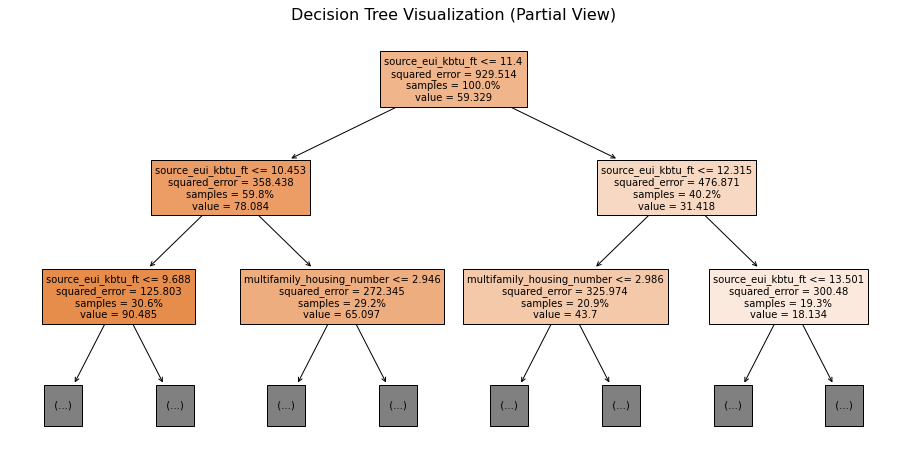

In [67]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

plt.figure(figsize=(16, 8))
plot_tree(dt_regressor, filled=True, feature_names=X.columns, max_depth=2, fontsize=10,
         proportion=True, impurity=True)
plt.title("Decision Tree Visualization (Partial View)", fontsize=16)
plt.show()

DecisionTreeRegressor(max_depth=1, random_state=42)

DecisionTreeRegressor(max_depth=2, random_state=42)

DecisionTreeRegressor(max_depth=3, random_state=42)

DecisionTreeRegressor(max_depth=4, random_state=42)

DecisionTreeRegressor(max_depth=5, random_state=42)

DecisionTreeRegressor(max_depth=6, random_state=42)

DecisionTreeRegressor(max_depth=7, random_state=42)

DecisionTreeRegressor(max_depth=8, random_state=42)

DecisionTreeRegressor(max_depth=9, random_state=42)

DecisionTreeRegressor(max_depth=10, random_state=42)

DecisionTreeRegressor(max_depth=11, random_state=42)

DecisionTreeRegressor(max_depth=12, random_state=42)

DecisionTreeRegressor(max_depth=13, random_state=42)

DecisionTreeRegressor(max_depth=14, random_state=42)

DecisionTreeRegressor(max_depth=15, random_state=42)

DecisionTreeRegressor(max_depth=16, random_state=42)

DecisionTreeRegressor(max_depth=17, random_state=42)

DecisionTreeRegressor(max_depth=18, random_state=42)

DecisionTreeRegressor(max_depth=19, random_state=42)

DecisionTreeRegressor(max_depth=20, random_state=42)

DecisionTreeRegressor(max_depth=21, random_state=42)

DecisionTreeRegressor(max_depth=22, random_state=42)

DecisionTreeRegressor(max_depth=23, random_state=42)

DecisionTreeRegressor(max_depth=24, random_state=42)

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Decision Tree Depth vs Mean Squared Error')

Text(0.5, 0, 'Tree Depth')

Text(0, 0.5, 'Mean Squared Error (MSE)')

([<matplotlib.axis.XTick at 0x1d9af7714f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

(array([-50.,   0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

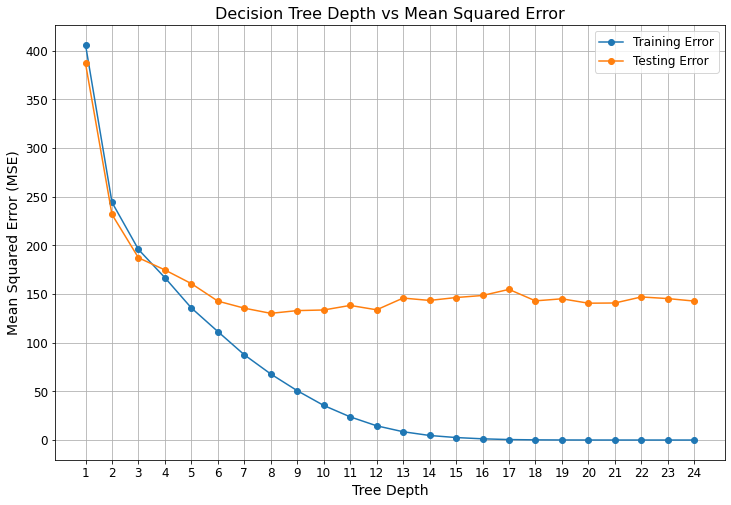

In [68]:
train_errors = []
test_errors = []
max_depths = range(1, 25)

for depth in max_depths:
    dt_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dt_regressor.fit(X_train, y_train)
    y_train_pred = dt_regressor.predict(X_train)
    y_test_pred = dt_regressor.predict(X_test)
    
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))

plt.figure(figsize=(12, 8))
plt.plot(max_depths, train_errors, label='Training Error', marker='o')
plt.plot(max_depths, test_errors, label='Testing Error', marker='o')
plt.title('Decision Tree Depth vs Mean Squared Error', fontsize=16)
plt.xlabel('Tree Depth', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.xticks(max_depths, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

RandomForestRegressor(random_state=42)

<Figure size 864x576 with 0 Axes>

<BarContainer object of 16 artists>

Text(0.5, 0, 'Feature Importance')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Feature Importance in Random Forest Regressor')

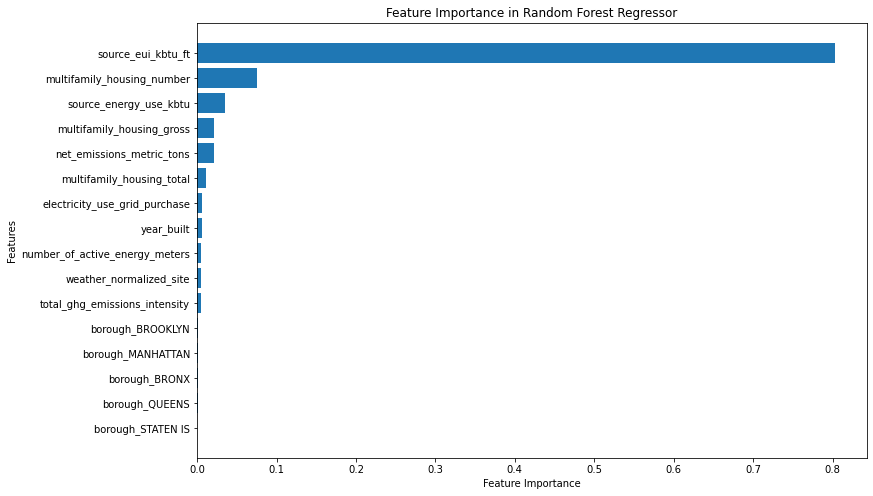

In [69]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train, y_train)

feature_importances = rf_regressor.feature_importances_

plt.figure(figsize=(12, 8))
sorted_idx = feature_importances.argsort()
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor')
plt.show()

RandomForestRegressor(random_state=42)

<Figure size 864x576 with 0 Axes>

<BarContainer object of 15 artists>

Text(0.5, 0, 'Feature Importance')

Text(0, 0.5, 'Features')

Text(0.5, 1.0, 'Feature Importance in Random Forest Regressor (Without source_eui_kbtu_ft)')

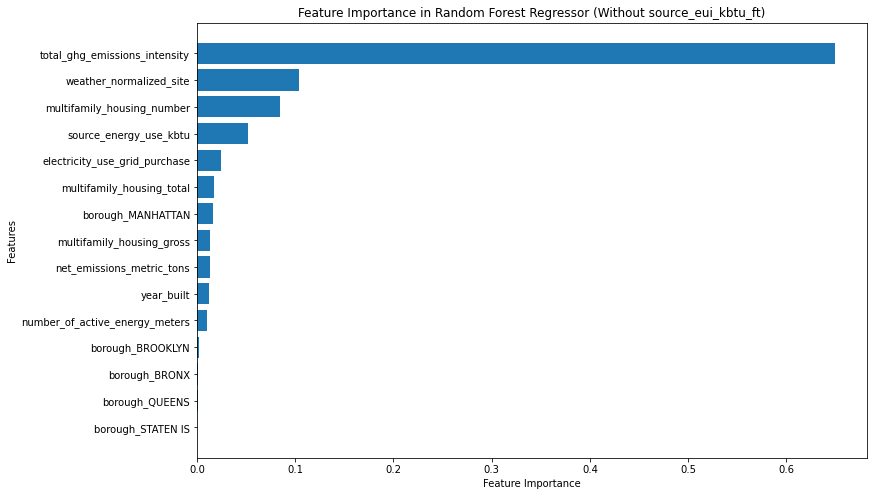

In [70]:
# Remove 'source_eui_kbtu_ft' from the dataset
X_train_reduced = X_train.drop('source_eui_kbtu_ft', axis=1)
X_test_reduced = X_test.drop('source_eui_kbtu_ft', axis=1)

# Train a new Random Forest Regressor without 'source_eui_kbtu_ft'
rf_regressor_reduced = RandomForestRegressor(random_state=42)
rf_regressor_reduced.fit(X_train_reduced, y_train)

# New Feature Importance
feature_importances_reduced = rf_regressor_reduced.feature_importances_

# Creating a new bar chart for feature importance without 'source_eui_kbtu_ft'
plt.figure(figsize=(12, 8))
sorted_idx_reduced = feature_importances_reduced.argsort()
plt.barh(X_train_reduced.columns[sorted_idx_reduced], feature_importances_reduced[sorted_idx_reduced])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest Regressor (Without source_eui_kbtu_ft)')
plt.show()

# Model Comparison

In [71]:
model_adjr2_results
model_mse_results

{'Full Regression Untransformed': 0.6754708091472847,
 'Full Regression Transformed': 0.7671723306132332,
 'Ridge': 0.7638531761719999,
 'Lasso Transformed': 0.7608761083143419,
 'PCR': 0.7140688219562819,
 'KNNR': 0.85880178254087,
 'DecisionTree': 0.8423920740487686,
 'RandomForest': 0.9228225112876572}

{'Full Regression Untransformed': 293.8435758625867,
 'Full Regression Transformed': 210.81282319348946,
 'Ridge': 213.81813746826862,
 'Lasso Transformed': 216.5137109006037,
 'PCR': 258.8951692949537,
 'KNNR': 127.84732558139535,
 'DecisionTree': 142.70542635658916,
 'RandomForest': 69.88002897286822}